Monte-Carlo simulation of axion sources in the Milky Way

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import LinearNDInterpolator
rng = np.random.default_rng() # random number generator

## Configuration and CSV file ingestion

In [9]:
masses = np.arange(9, 31) # Msun
mass_range = np.linspace(np.min(masses), np.max(masses), int(1e3))

coupling = -10

isotopes = [
    'c12', 
    'o16', 
    'ne20', 
    'na23',
]

# what we read from the CSV files
labels = list(({
    # 'model': 'slice',
    'm': 'mass (Msun)',
    # 'coupling': 'coupling',
    # 'age': 'age (years)',
    'til': 'time to core O depletion (years)',
    # 'dt': 'dt (years)',
    
    # 'm_enc': 'mass enclosed (Msun)',
    # 'dm': 'dm (g)',
    # 'r': 'r (Rsun)',
    # 'dr': 'dr (cm)',
    # 'T': 'T (K)',
    # 'T_core': 'core T (K)',
    # 'T_eff': 'effective T (K)',
    # 'log_T': 'log T',
    
    # 'eps_grav': 'eps_grav (ergs/g s)',
    # 'eps_nuc': 'eps_nuc (ergs/g s)', 
    # 'eps_non_nuc_neu': 'eps_neu (ergs/g s)',
    # 'eps_a': 'eps_a (ergs/g s)',
    
    # 'lum_gamma': 'lum_gamma (ergs/s)',
    # 'lum_neu': 'lum_neu (ergs/s)',
    # 'lum_a': 'lum_a (ergs/s)',
    
    'lum_gamma_surf': 'surface lum_gamma (ergs/s)',
    # 'lum_neu_surf': 'surface lum_neu (ergs/s)',
    'lum_a_surf': 'surface lum_a (ergs/s)',
    # 'num_a_surf': 'surface num_a (/s)',
    
    # 'cum_e_gamma': 'cumulative e_gamma (ergs)',
    # 'cum_e_neu': 'cumulative e_neu (ergs)',
    # 'cum_e_a': 'cumulative e_a (ergs)',
}).values())

lumSun = 3.846e33 # ergs/s
cm_per_kpc = 3.086e21
max_slices = 100000000
num_per_erg = 1.41853e6 # /erg

In [10]:
datatable = dict()

for m in masses:
    try:
        key = f'm{m:04.1f}_g{coupling:+04.2f}_0'
        # run = pd.read_csv(f'csv/{key}/index.csv')
        run = pd.read_csv(f'csv_simplified/index{m:02}.csv')
        entry = run[labels].to_numpy()[:max_slices].T
        datatable[m] = entry
        print(key, end=',\t')
    except FileNotFoundError as e:
        print(e)

m09.0_g-10.00_0,	m10.0_g-10.00_0,	m11.0_g-10.00_0,	m12.0_g-10.00_0,	m13.0_g-10.00_0,	m14.0_g-10.00_0,	m15.0_g-10.00_0,	m16.0_g-10.00_0,	m17.0_g-10.00_0,	m18.0_g-10.00_0,	m19.0_g-10.00_0,	m20.0_g-10.00_0,	m21.0_g-10.00_0,	m22.0_g-10.00_0,	m23.0_g-10.00_0,	m24.0_g-10.00_0,	m25.0_g-10.00_0,	m26.0_g-10.00_0,	m27.0_g-10.00_0,	m28.0_g-10.00_0,	m29.0_g-10.00_0,	m30.0_g-10.00_0,	

## Probability distributions

In [11]:
s0 = 0.0686 # kpc, bulge radius from galaxy center
se = 8.5 # kpc, earth radius from galaxy center
alpha = 0.74 # Verberne & Vink
beta = -3.52 # Verbene & Vink
fs0 = lambda s: ((s + s0)/se)**alpha * np.exp(beta * (s/se))

z0 = 0.4 # kpc, disk scale height
fz0 = lambda z: np.exp(-np.abs(z)/z0)

def fr0(r):
    theta_range = np.linspace(0, 2*np.pi, 300)
    phi_range = np.linspace(0, np.pi, 300)
    R, Theta, Phi = np.meshgrid(r, theta_range, phi_range)

    zz = np.nan_to_num(R*np.cos(Phi), 0)
    ss = np.nan_to_num(np.sqrt((R*np.sin(Phi))**2 + se**2 - 2*se*R*np.cos(Theta)*np.sin(Phi)), 0)

    return np.sum(
        R*R*np.sin(Phi) * fz0(zz) * fs0(ss),
        axis=(0,2)
   )

norm = lambda x: x / np.sum(x)
fr = lambda r: norm(fr0(r))

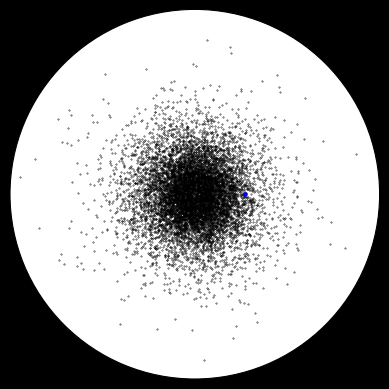

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=100, facecolor='black')
ax.set_rmin(0)
ax.set_rmax(30)
ax.set_rticks([])  # Move radial labels away from plotted line
ax.grid(False)
ax.set_thetagrids([])

# ax.set_title("A line plot on a polar axis", va='bottom')

srange = np.linspace(0, 30, 10000)
trange = np.linspace(0, 2*np.pi, 10000)
sp = norm(2*np.pi * srange * fs0(srange))
size = 10000
schoice = np.random.choice(srange, size=size, p=sp)
tchoice = np.random.choice(trange, size=size)
ax.scatter(tchoice, schoice, s=0.1, color='black')
ax.scatter([0], [se], s=5, color='blue')

In [13]:
r_range = np.linspace(0, 30, 200)
graph = fr(r_range)

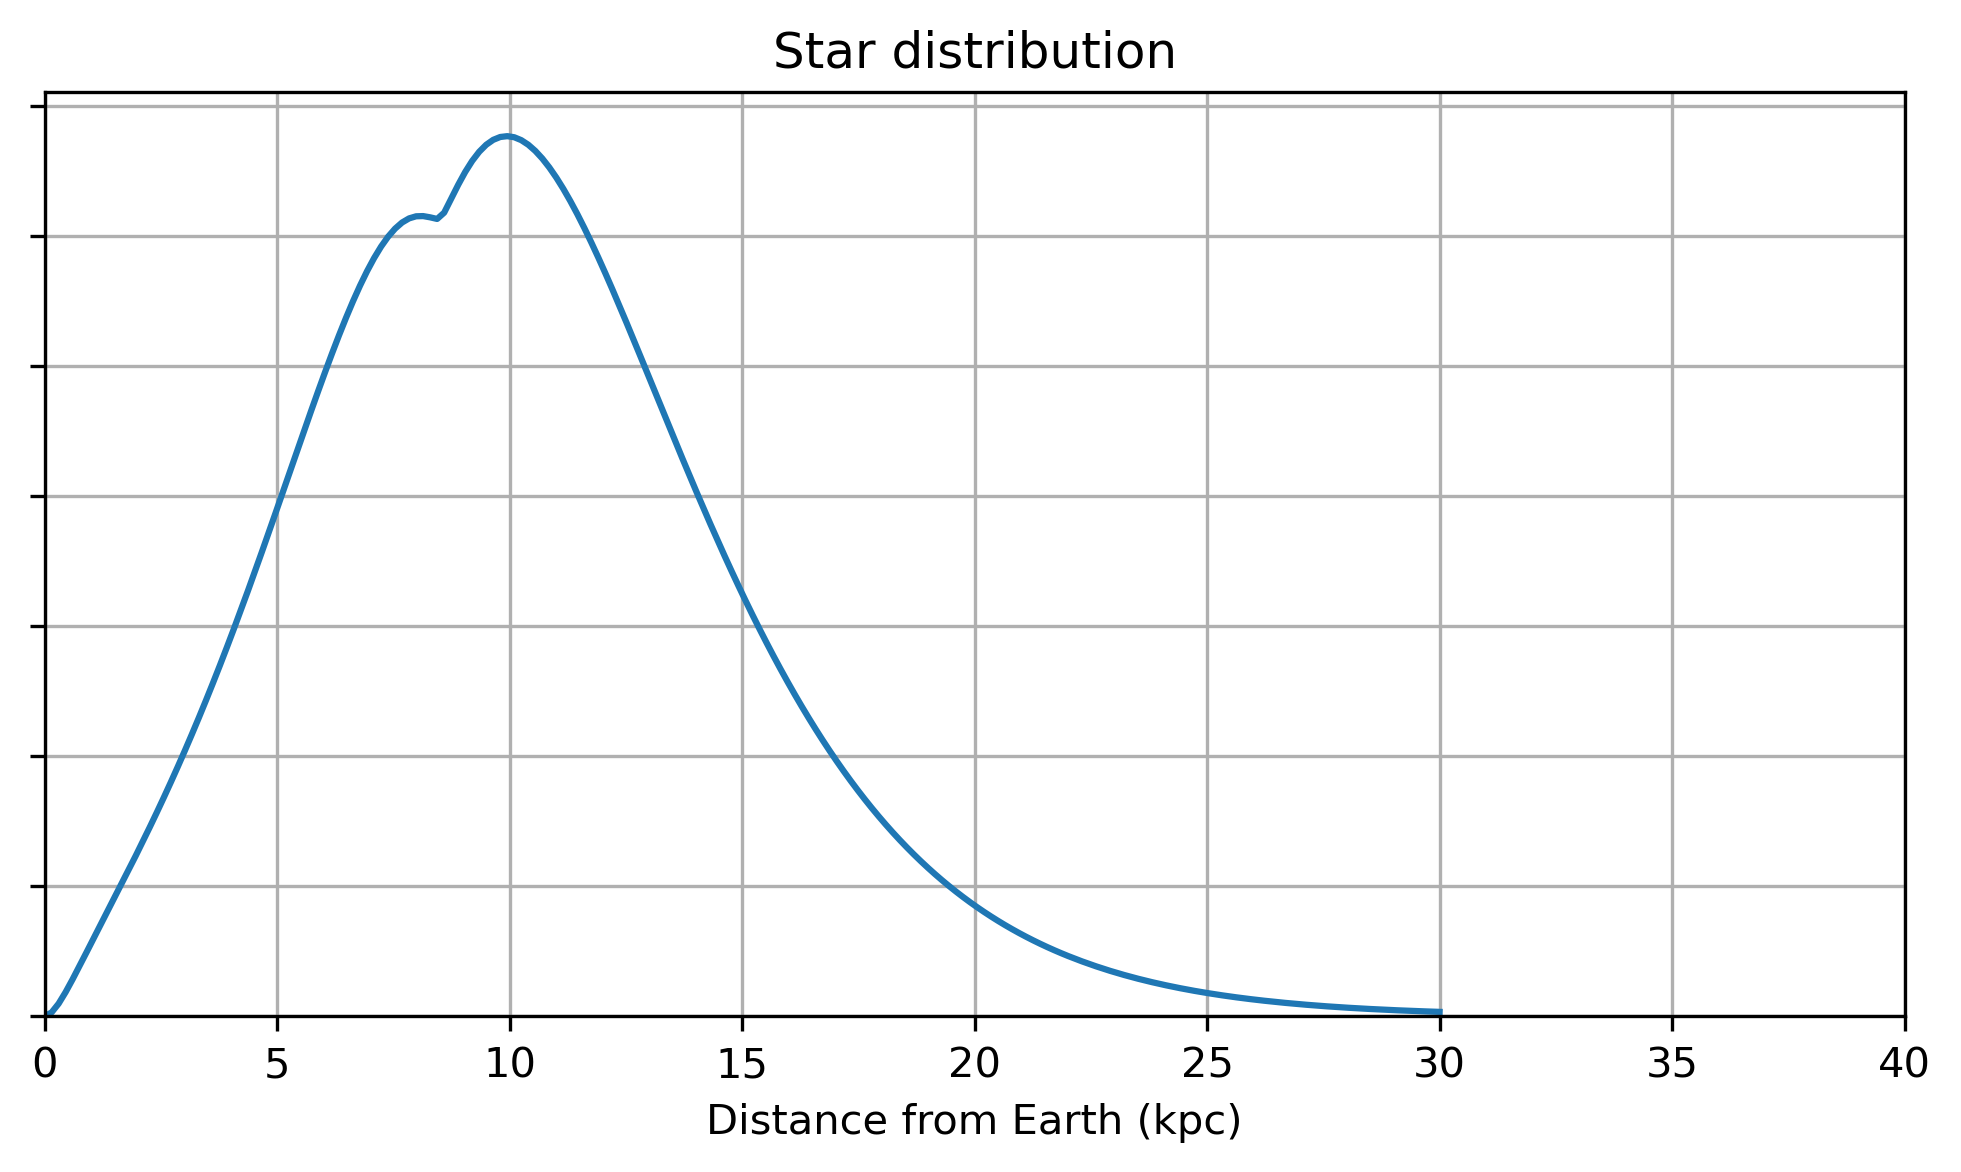

In [14]:
fig, ax = plt.subplots(dpi=300, facecolor='white', figsize=(8, 4))
plt.plot(r_range, graph)
plt.xlabel("Distance from Earth (kpc)")
# plt.ylabel("Discrete probability")
ax.get_yaxis().set_ticklabels([])
plt.ylim(0)
plt.xlim(0, 40)
plt.title("Star distribution")
plt.grid()

In [15]:
(
    np.sum((graph/r_range**2)[np.logical_and(r_range>0.01, r_range<2.11)])
    /
    np.sum((graph/r_range**2)[r_range>0.01])
)

/tmp/ipykernel_94284/107993713.py:2: RuntimeWarning: invalid value encountered in divide
  np.sum((graph/r_range**2)[np.logical_and(r_range>0.01, r_range<2.11)])
/tmp/ipykernel_94284/107993713.py:4: RuntimeWarning: invalid value encountered in divide
  np.sum((graph/r_range**2)[r_range>0.01])


0.4709551452628646

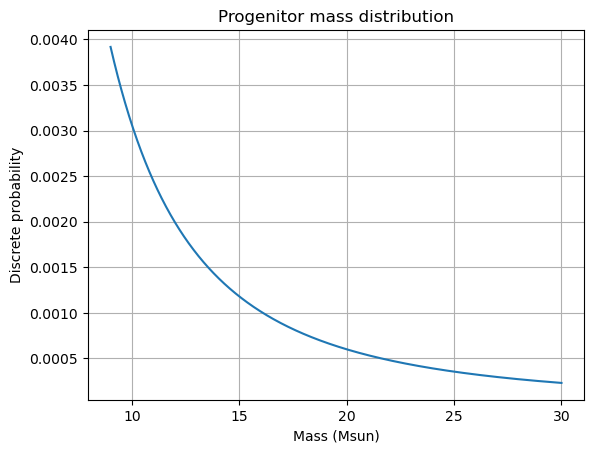

In [16]:
# inverse of initial mass function
imf0 = lambda m: m**(-2.35)
imf = lambda m: norm(imf0(m))
plt.plot(mass_range, imf(mass_range))
plt.grid()
plt.xlabel('Mass (Msun)')
plt.ylabel('Discrete probability')
plt.title("Progenitor mass distribution")
plt.show()

## Sampling

In [17]:
freq = 1/40 # SN per year
r_range = np.linspace(0, 100, 1000) # kpc
r_pmf = fr(r_range)
m_pmf = imf(mass_range)


In [18]:
lum_g_list = []
num_a_list = []
for i in range(100):
    lum_g_t = 0
    num_a_t = 0
    
    rlist = []
    mlist = []
    nlist = []

    endtime = 100000 # years
    poisson = np.random.poisson(freq, endtime)
    times = np.arange(endtime)[poisson > 0]
    for t0 in times:
        t = t0 + rng.random()
        r = np.random.choice(r_range, p=r_pmf)
        r2 = 4 * np.pi * (r * cm_per_kpc)**2 # cm^2
        m = int(np.round(np.random.choice(mass_range, p=m_pmf)))
        rlist.append(r)
        mlist.append(m)
        
        entry = datatable[m]
        t_raw, lum_g_t_raw, lum_a_t_raw = entry[1:]
    
        lum_g_t += np.interp(-t, -t_raw, lum_g_t_raw, left=0, right=0) / r2
        num_a_t += 10 * np.interp(-t, -t_raw, lum_a_t_raw, left=0, right=0) * num_per_erg / r2
        nlist.append(10 * np.interp(-t, -t_raw, lum_a_t_raw, left=0, right=0)* num_per_erg)

    lum_g_list.append(lum_g_t)
    num_a_list.append(num_a_t)
    
    # print(f"{lum_g_t:.3f} photon ergs/cm^2 sec")
    # print(f"{num_a_t:.3f} axions/cm^2 sec")

Text(0, 0.5, 'runs')

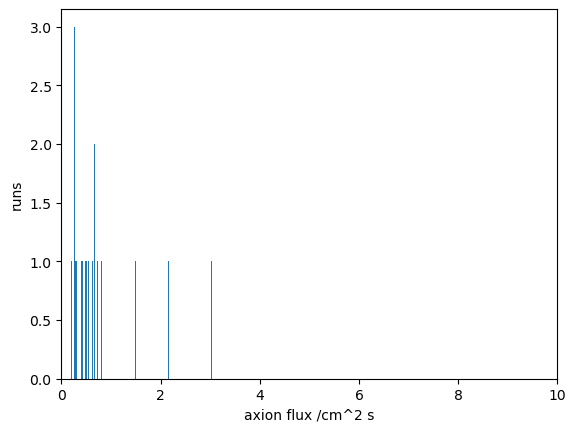

In [19]:
plt.hist(num_a_list, bins=1000)
plt.xlabel("axion flux /cm^2 s")
plt.xlim(0,10)
plt.ylabel('runs')

In [20]:
np.mean(num_a_list)

0.7004717034916659

Text(0, 0.5, 'counts')

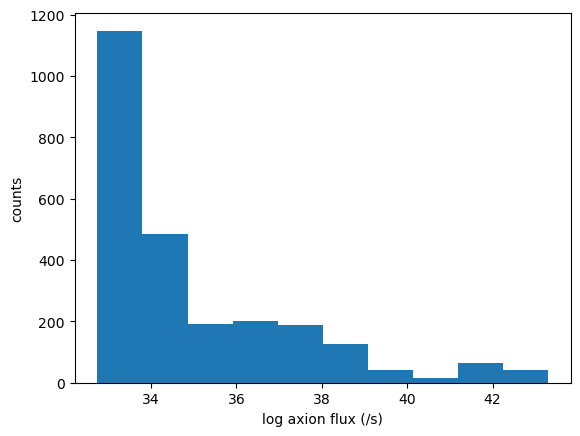

In [29]:
plt.hist(np.log10(nlist), bins=10)
plt.xlabel('log axion flux (/s)')
plt.ylabel('counts')

Text(0, 0.5, 'sample frequency')

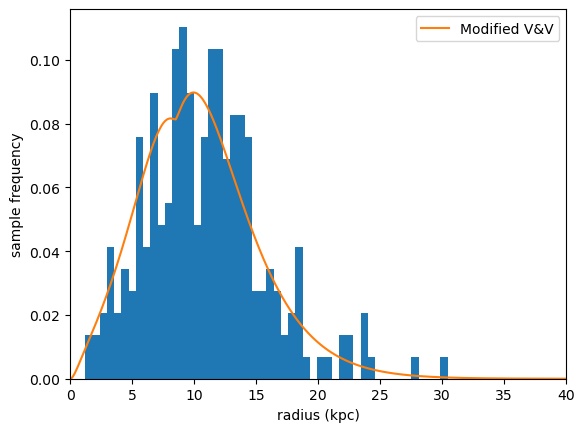

In [46]:
plt.hist(rlist, bins=50, density=True)
plt.plot(r_range, r_pmf*10, label='Modified V&V')
plt.xlim(0,40)
plt.legend()
plt.xlabel('radius (kpc)')
plt.ylabel('sample frequency')

Text(0, 0.5, 'sample frequency')

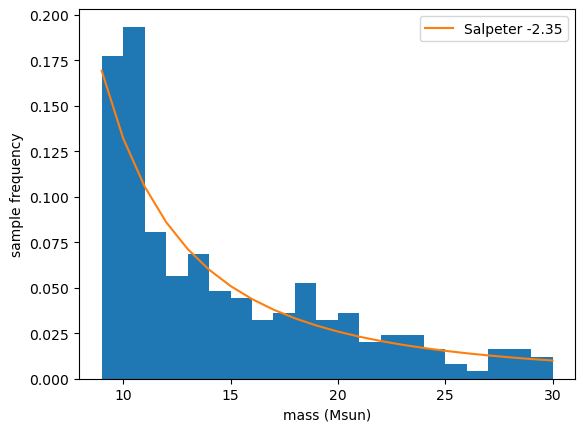

In [37]:
plt.hist(mlist, bins=21, density=True)
plt.plot(masses, m_pmf, label='Salpeter -2.35')
plt.legend()
plt.xlabel('mass (Msun)')
plt.ylabel('sample frequency')